<a href="https://colab.research.google.com/github/nam157/ai4theblind/blob/main/trainning_ssd_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nam157/ai4theblind.git

Cloning into 'ai4theblind'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 98 (delta 19), reused 55 (delta 3), pack-reused 0
Unpacking objects: 100% (98/98), done.


Vào thư mục /content/ai4theblind/object_detection/data/data_loader/prepare_data.py thay đổi đường dẫn data

In [ ]:
exec(open("/content/ai4theblind/object_detection/data/data_loader/prepare_data.py").read())

In [ ]:
import sys
sys.path.insert(0,'/content/ai4theblind/object_detection/')

In [19]:
from lib import *
from data.data_loader.make_datapath import make_datapath_list
from data.data_loader.dataset import MyDataset, my_collate_fn
from data.data_loader.transform import DataTransform
from data.data_loader.extract_inform_annotation import Anno_xml
from models.model import SSD
from multiboxloss import MultiBoxLoss
import torch

Vào thư mục /content/ai4theblind/object_detection/train.py thay đổi đường dẫn data

In [ ]:
exec(open("/content/ai4theblind/object_detection/train.py").read())

In [21]:
from google.colab.patches import cv2_imshow

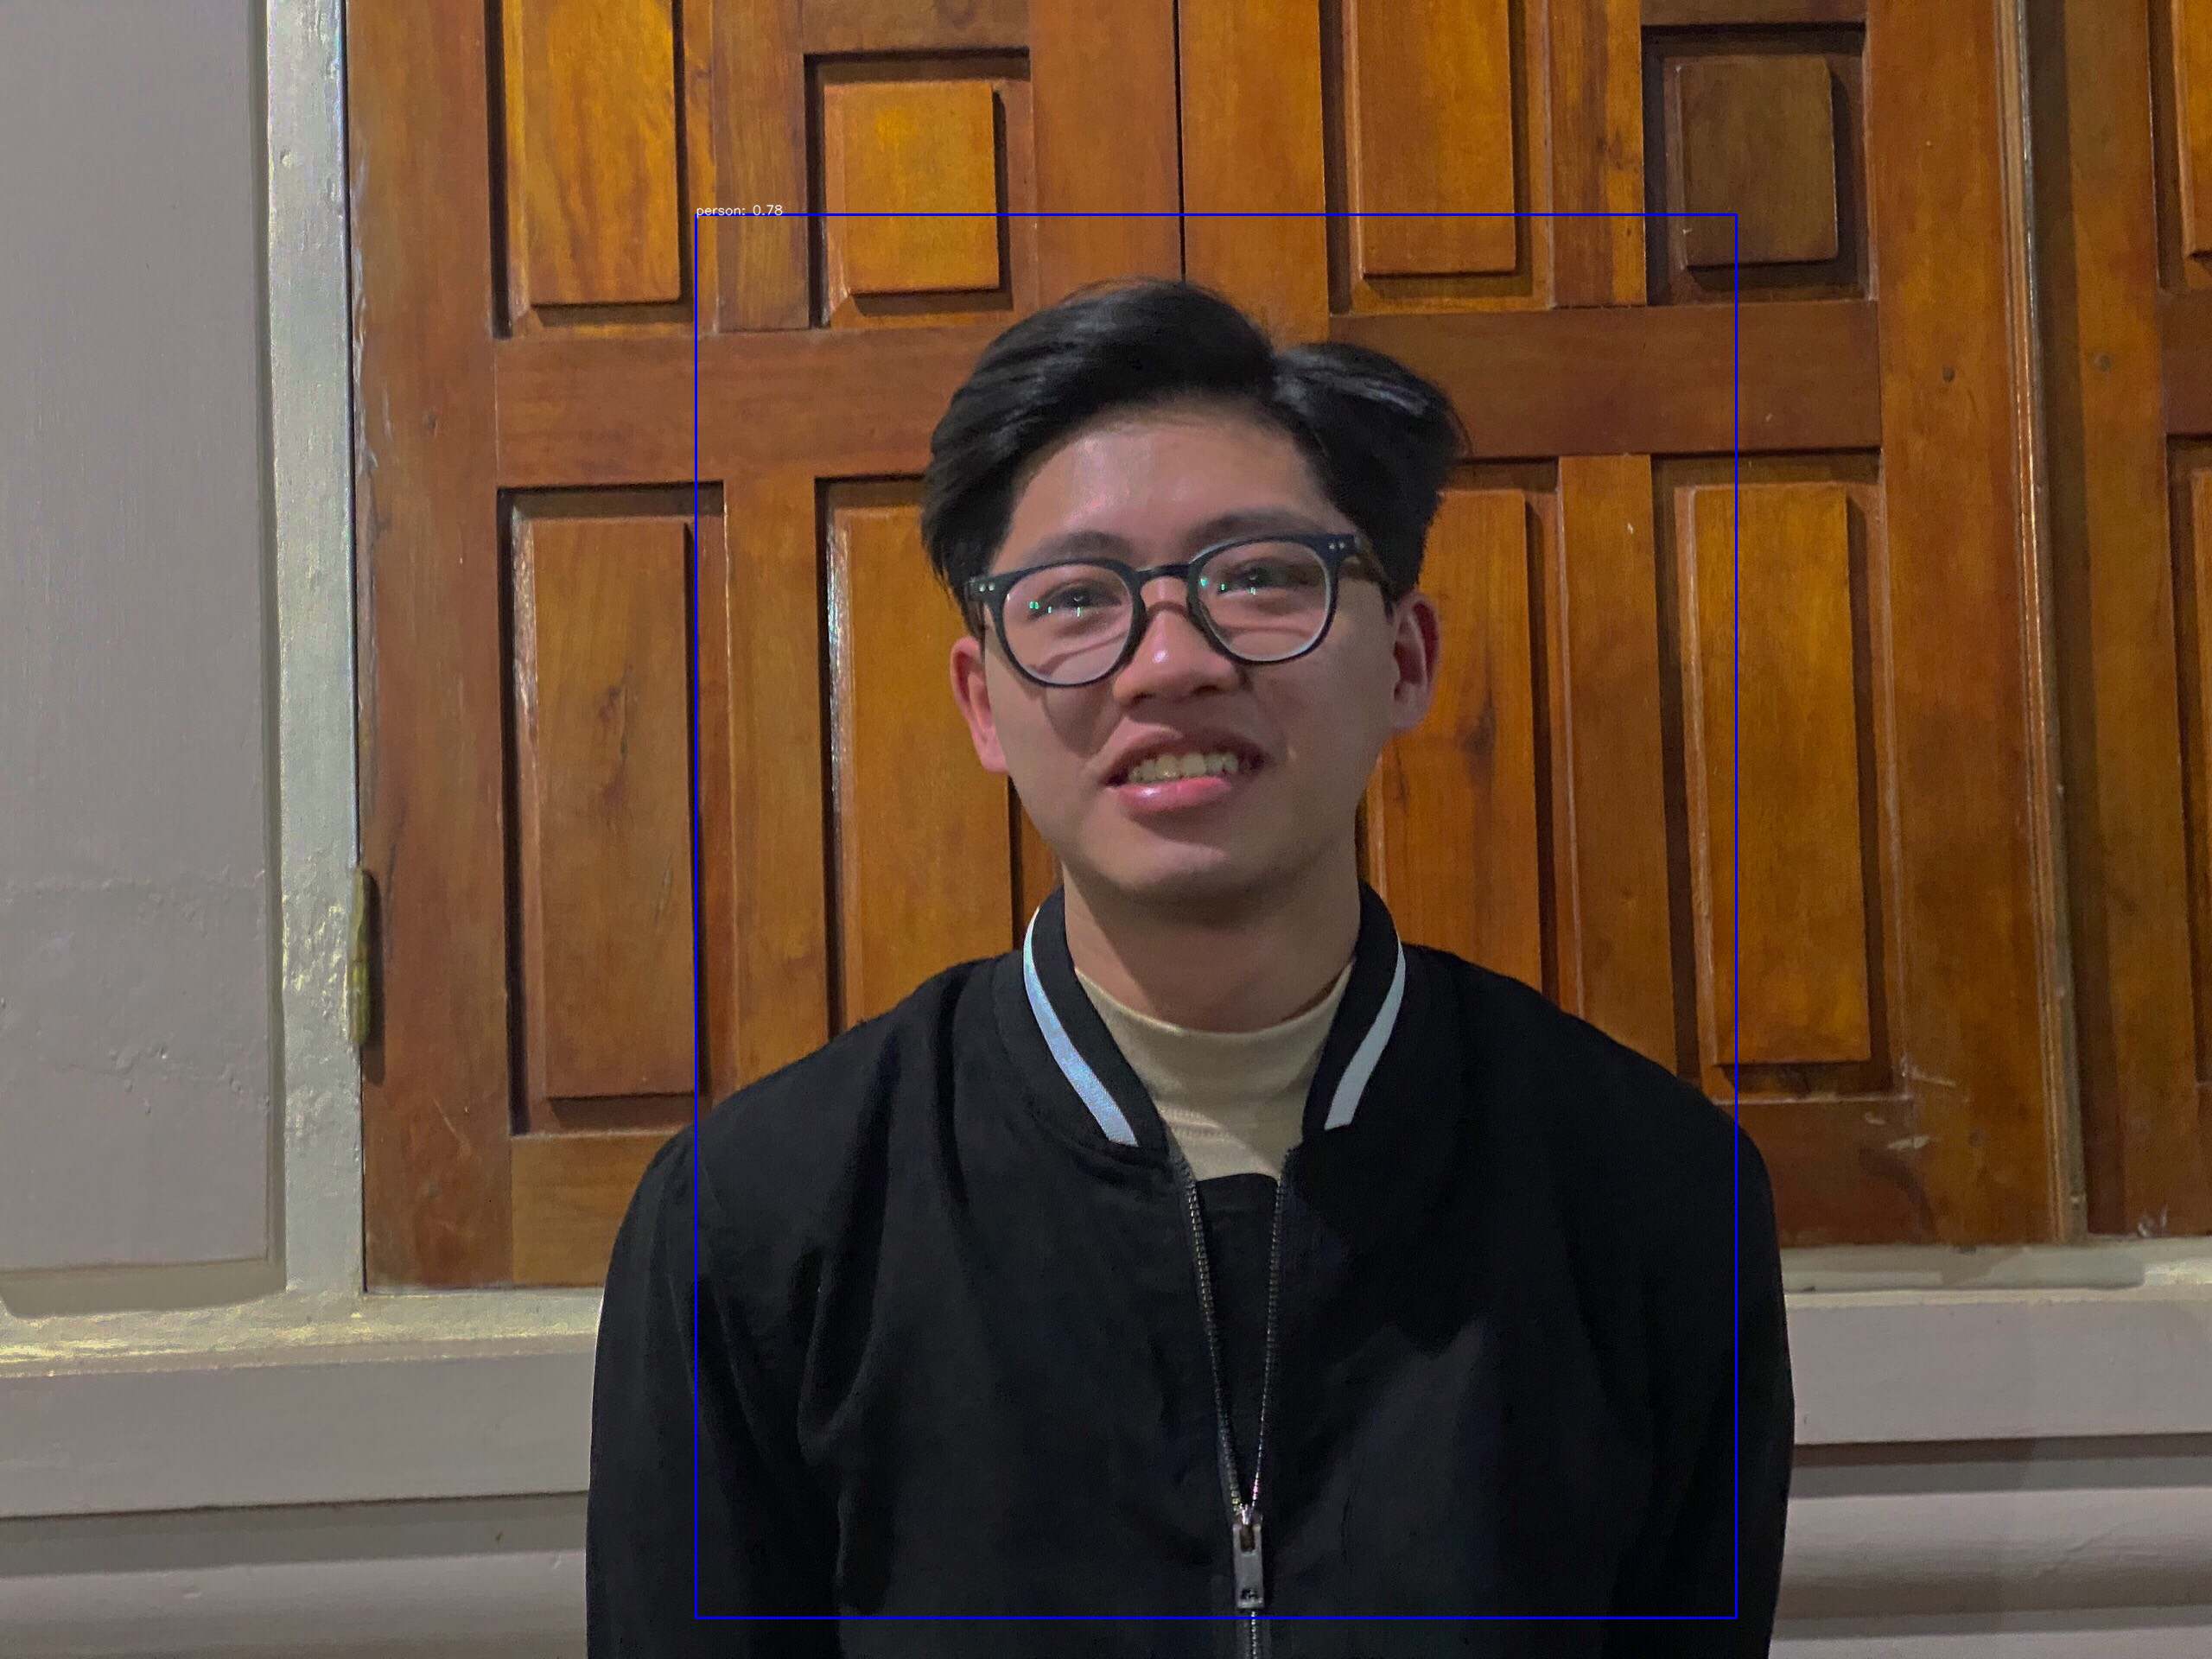

<Figure size 720x720 with 0 Axes>

In [24]:

classes = ["aeroplane", "bicycle", "bird",  "boat", "bottle", 
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"]

cfg = {
    "num_classes": 21, #VOC data include 20 class + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

net = SSD(phase="inference", cfg=cfg)
net_weights = torch.load("/content/ai4theblind/object_detection/data/weights/ssd300_10.pth", map_location={"cuda:0":"cpu"})
net.load_state_dict(net_weights)

def show_predict(img_file_path):
    img = cv2.imread(img_file_path)

    color_mean = (104, 117, 123)
    input_size = 300
    transform = DataTransform(input_size, color_mean)

    phase = "val"
    img_tranformed, boxes, labels = transform(img, phase, "", "")
    img_tensor = torch.from_numpy(img_tranformed[:,:,(2,1,0)]).permute(2,0,1)

    net.eval()
    input = img_tensor.unsqueeze(0) #(1, 3, 300, 300)
    output = net(input)

    plt.figure(figsize=(10, 10))
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    font = cv2.FONT_HERSHEY_SIMPLEX

    detections = output.data #(1, 21, 200, 5) 5: score, cx, cy, w, h
    scale = torch.Tensor(img.shape[1::-1]).repeat(2)

    for i in range(detections.size(1)):
        j = 0
        while detections[0, i, j, 0] >= 0.6:
            score = detections[0, i, j, 0]
            pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
            cv2.rectangle(img,
                          (int(pt[0]), int(pt[1])),
                          (int(pt[2]), int(pt[3])),
                          colors[i%3], 2
                          )
            display_text = "%s: %.2f"%(classes[i-1], score)
            cv2.putText(img, display_text, (int(pt[0]), int(pt[1])),
                font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            j += 1
    
    cv2_imshow(img)


if __name__ == "__main__":
    img_file_path = "nam.jpg"
    show_predict(img_file_path)